In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanSquaredError
from keras.layers import (BatchNormalization, Dense, TimeDistributed, Bidirectional, SimpleRNN, GRU, LSTM, Dropout, Input)
from keras import layers

2023-07-31 11:37:34.833405: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 11:37:35.238597: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 11:37:35.241270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 11:37:38.622459: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#Leemos el fichero que contiene todas las lecturas desde el 2009 sin elementos faltantes.
data = pd.read_csv("data/historic_demand_2009_2023_noNaN.csv", index_col = 'settlement_date', parse_dates=True)

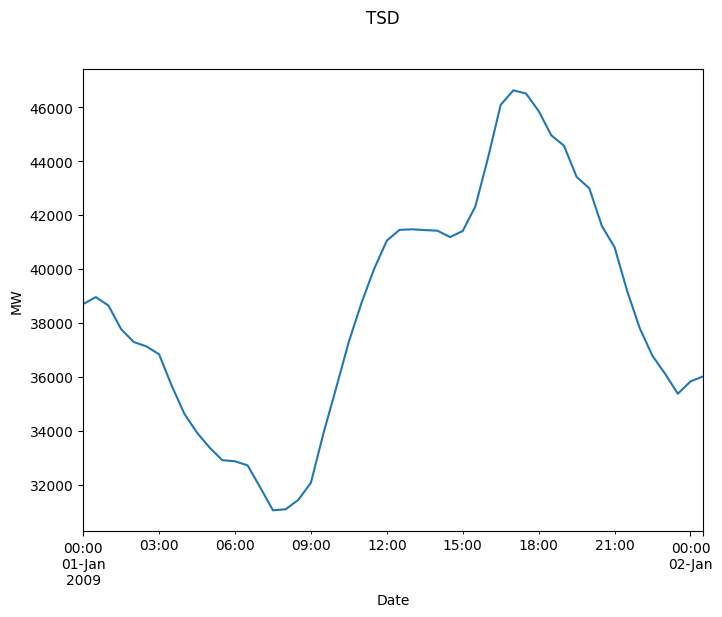

In [ ]:
#df = df[::2]      #Submuestreo (1 muestra cada 1 hora)

#En un rango de tiempo
df = data.copy()
plot_features = df['tsd'][:50]
_ = plot_features.plot(subplots=True, figsize=(8,6), ylabel="MW", xlabel="Date", title='TSD')

In [ ]:
df = pd.DataFrame(df['tsd'])
df.head()

,tsd
settlement_date,
2009-01-01 00:00:00,38704
2009-01-01 00:30:00,38964
2009-01-01 01:00:00,38651
2009-01-01 01:30:00,37775
2009-01-01 02:00:00,37298


In [ ]:
def split_data(df, split=0.2):
  n = int(len(df) * split)
  train, val = df.iloc[:-n], df.iloc[-n:]
  assert len(train) + len(val) == len(df)
  return train, val

def fit_norm(train, val, test):
  train_mean, train_std = train.mean(), train.std()
  train_n = (train - train_mean)/train_std
  val_n = (val - train_mean)/train_std
  test_n = (test - train_mean)/train_std
  return train_mean, train_std, train_n, val_n, test_n

def denorm(mean, std, df):
  return (df * std) + mean

def denorm_y(mean, std, df):
  return (df * std[-1])+mean[-1]

def features_target_ts(*args):
  y = [col.pop('y_tsd').values.reshape(-1, 1) for col in args]
  x = [col.values.reshape(*col.shape, 1)
                   for col in args]
  return *y, *x

def plot_forecast(model, x_test, y_test, index, history):
  fig, ax = plt.subplots(2, 1)
  (pd.Series(history.history['loss']).plot(title='Loss by Epoch', ax = ax[0], label='loss', color='red'))
  (pd.Series(history.history['val_loss']).plot(ax=ax[0],label='val_loss', color='blue'))
  ax[0].legend()
  predicted = model.predict(x_test)
  pd.Series(y_test.reshape(-1), index=index).plot(ax=ax[1], title='Forecast vs Actual', label='actual',color='red')
  pd.Series(predicted.reshape(-1), index=index).plot(label='forecast', ax=ax[1], color='blue')
  fig.tight_layout()
  ax[1].legend();plt.show()


#adaptar dataset a la dimension de la ventana (window). Cada paso de prediccion toma el ancho de la ventana como entrada
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y_tsd'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

##La lógica que se emplea para hacer predicciones al futuro es igual que la de un paso (se toman x cantidad de muestras para predecir el siguiente paso), pero empleando el método Recursivo planteado en "Machine Learning Strategies for Time Series Forecasting" que consiste en que la última predicción realizada pasa a ser parte de la entrada para la siguiente y así hasta llegar al punto deseado.

##Al estar realizando nuevas predicciones con datos de entradas con errores (predichos anteriormente), estos errores aumentan con el paso del tiempo, por lo que predicciones extendidas en el tiempo no son aconsejables por este problema.




In [ ]:
def multi_step_forecast(data, model, steps=12000):
  forecast = []
  for i in range(steps):
    stp_pred = model(data, training=False)
    print(stp_pred)
    forecast.append(stp_pred)
    data[0] = np.append((np.delete(data[0],0)),stp_pred).reshape(672,1)
    np.append(data,stp_pred)
  return np.array(forecast)

In [ ]:
def shw_test_pred(pred):
  df_p = pd.DataFrame(pred)
  df_p.index = test.index
  df_p.columns = ["pred_tsd"]

  df_p = denorm_y(train_mean,train_std,df_p)
  df_p.reset_index(inplace=True)
  #df_p.head()

  df_p['settlement_date'] = pd.to_datetime(df_p['settlement_date'])

  date = df_p['settlement_date']
  value = df_p['pred_tsd']

  plt.figure(figsize=(15,6))
  plt.title("TSD Predicted")
  value.index=date
  value.plot(xlabel = "Date", ylabel = "MW", c='red', )

In [ ]:
#Split data
df_w = one_step_forecast(df, 672)

df_test = df_w.loc["2023-01-01 00:00:00":]       #Datos del 2023 para testear
df_w = df_w.loc[:"2022-12-31 23:30:00"]

df_train, df_val = split_data(df_w)
train_mean, train_std, train, val, test = fit_norm(df_train, df_val, df_test)

(y_train, y_val, y_test, x_train, x_val, x_test) = features_target_ts(train, val, test)

In [ ]:
date_to_pred = pd.date_range(start='2023-04-26', end='2024-01-01', freq='30T')[:-1]
x_test_pred = x_test[-1:]
date_to_pred.shape

(12000,)

##Los modelos presentados en este notebook son basados Deep Learning, específicamente Redes Neuronales Recurrentes, dentro de estas Long-short Term Memory (LSTM)

##Se presenta tambien un modelo combinado con una ConvNet CNN-LSTM. Es un enfoque que ha tomado mucha fuerza en los últimos tiempos debido a las ventajas probadas de cada modelo en distintas áreas (CNN-imágenes y LSTM-lenguaje).


## LSTM

In [ ]:
tf.keras.backend.clear_session()

#SimpleRNN
#model = keras.Sequential()
#model.add(SimpleRNN(units=32, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
#model.add(Dropout(0.2))
#model.add(Dense(1))

#LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=32, input_shape=(x_train.shape[1], x_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.summary()

lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError()])
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
history = lstm_model.fit(x_train, y_train, shuffle=False, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
6117/6117 [==============================] - 153s 24ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - root_mean_squared_error: 0.1994 - mean_absolute_error: 0.1306 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_root_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.0456
Epoch 2/50
6117

In [ ]:
#lstm_model = tf.keras.models.load_model('/content/drive/MyDrive/lstm.keras')

In [ ]:
lstm_model.save('/content/drive/MyDrive/lstm.keras')

In [ ]:
lstm_model.evaluate(x=x_test, y=y_test)

152/152 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - root_mean_squared_error: 0.0619 - mean_absolute_error: 0.0473


[0.0038353786803781986,
 0.0038353786803781986,
 0.06193043291568756,
 0.04725482314825058]

In [ ]:
history.history

{'loss': [0.039766669273376465,
  0.012925057671964169,
  0.012181420810520649,
  0.011832596734166145,
  0.011690019629895687,
  0.011481638997793198,
  0.011452111415565014,
  0.01138025987893343,
  0.0112838139757514,
  0.011213626712560654,
  0.011225184425711632,
  0.011105041019618511,
  0.011005372740328312,
  0.011119188740849495,
  0.0111111830919981,
  0.0109655587002635,
  0.010940980166196823,
  0.010913770645856857,
  0.01095049548894167,
  0.010883009992539883,
  0.010856502689421177,
  0.010822538286447525,
  0.010927791707217693,
  0.010906979441642761],
 'mean_squared_error': [0.039766669273376465,
  0.012925057671964169,
  0.012181420810520649,
  0.011832596734166145,
  0.011690019629895687,
  0.011481638997793198,
  0.011452111415565014,
  0.01138025987893343,
  0.0112838139757514,
  0.011213626712560654,
  0.011225184425711632,
  0.011105041019618511,
  0.011005372740328312,
  0.011119188740849495,
  0.0111111830919981,
  0.0109655587002635,
  0.010940980166196823,


152/152 [==============================] - 2s 8ms/step


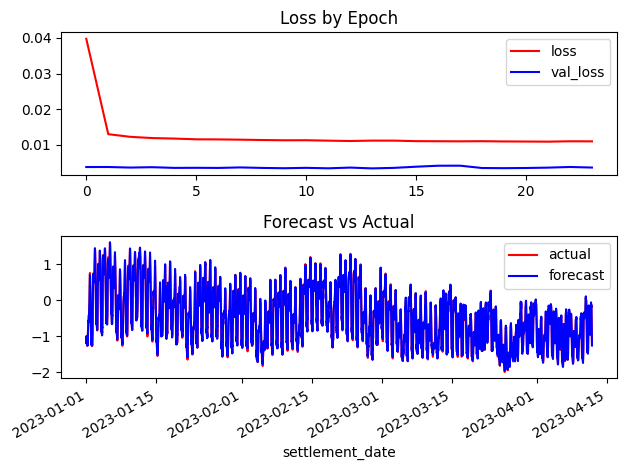

In [ ]:
plot_forecast(lstm_model, x_test, y_test, test.index, history)

In [ ]:
predicted = lstm_model(x_test)

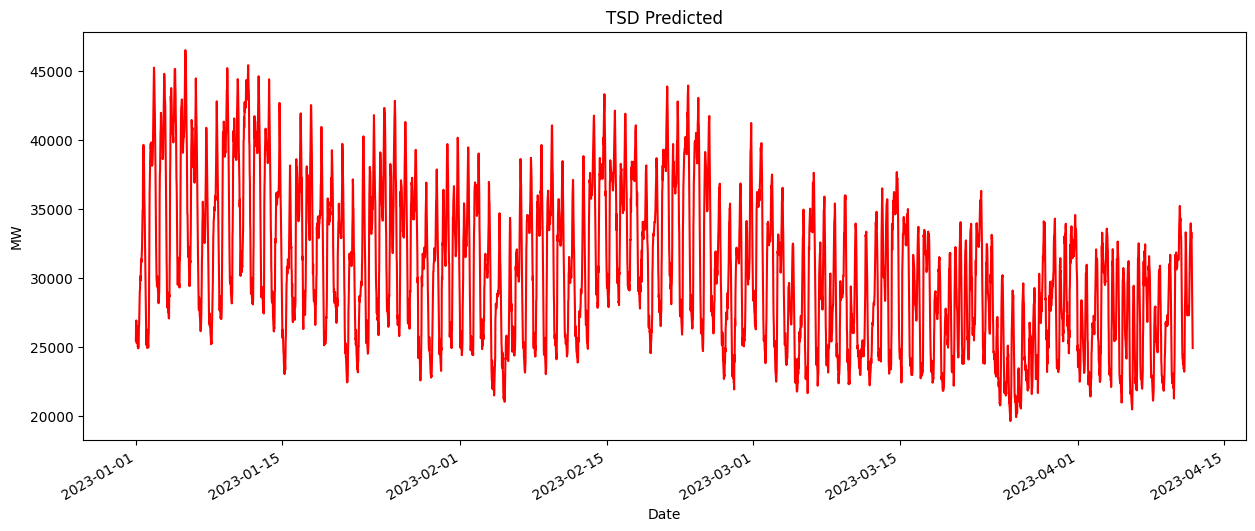

In [ ]:
shw_test_pred(predicted)

In [ ]:
future_pred = multi_step_forecast(x_test_pred, lstm_model)
future_pred = future_pred.reshape(12000,1)


Streaming output truncated to the last 5000 lines.
tf.Tensor([[-0.403602]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.40753976]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.42586648]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.45692238]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.4984263]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.54746854]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.60058725]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.654032]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.704268]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.74865985]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.78611195]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.81735504]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.84466636]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.87107825]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.89940107]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9314518]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.96769905]], shape=(1, 1), dtype=float32)
tf.Te

<Axes: xlabel='Date', ylabel='MW'>

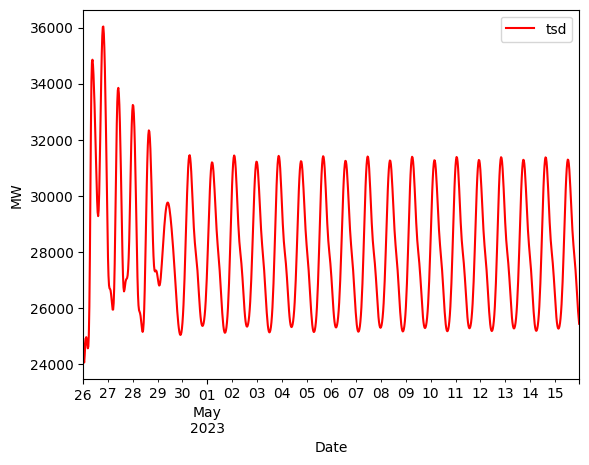

In [ ]:
#plt.figure(figsize=(15,6))
#plt.title("TSD Future")
df_future = pd.DataFrame(future_pred)
df_future.index = date_to_pred
df_future.columns = ['tsd']

df_fu = denorm_y(train_mean,train_std,df_future)
df_fu_t = df_fu[:960]
df_fu_t.plot(xlabel = "Date", ylabel = "MW", c='red', )

## Modelo con 2 LSTM intermedias


In [ ]:
tf.keras.backend.clear_session()
from keras import Model
#LSTM_2

input_data = Input(shape=(x_train.shape[1], x_train.shape[2]))
lstm_1 = LSTM(64, return_sequences=True)(input_data)
dropout_1 = Dropout(0.2)(lstm_1)
lstm_2 = LSTM(32)(dropout_1)
dropout_2 = Dropout(0.2)(lstm_2)
output = Dense(1)(dropout_2)

lstm_2_model = Model(inputs=input_data, outputs=output)

lstm_2_model.summary()

lstm_2_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError()])
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
history_2 = lstm_2_model.fit(x_train, y_train, shuffle=False, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

In [ ]:
tf.keras.backend.clear_session()

#LSTM_2

lstm_2_model = Sequential()
lstm_2_model.add(layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
lstm_2_model.add(layers.Dropout(0.2))
lstm_2_model.add(layers.LSTM(32))
lstm_2_model.add(layers.Dropout(0.2))
lstm_2_model.add(layers.Dense(1))

lstm_2_model.summary()

lstm_2_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError()])
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
history_2 = lstm_2_model.fit(x_train, y_train, shuffle=False, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 672, 64)           16896     
                                                                 
 dropout (Dropout)           (None, 672, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
6117/6117 [==============================

In [ ]:
lstm_2_model.evaluate(x=x_test, y=y_test)

152/152 [==============================] - 3s 20ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - root_mean_squared_error: 0.0654 - mean_absolute_error: 0.0496


[0.004275822546333075,
 0.004275822546333075,
 0.06538977473974228,
 0.04963334649801254]

In [ ]:
lstm_2_model.save('/content/drive/MyDrive/lstm_2.keras')

In [ ]:
history_2.history

{'loss': [0.032029569149017334,
  0.014040200971066952,
  0.013015992939472198,
  0.01267280150204897,
  0.01243644393980503,
  0.012149487622082233,
  0.012122410349547863,
  0.011842924170196056,
  0.011864330619573593,
  0.011755537241697311,
  0.0114948945119977,
  0.011646699160337448,
  0.011509953998029232,
  0.011480756103992462,
  0.01138383336365223,
  0.011370508931577206,
  0.011232364922761917,
  0.011056177318096161,
  0.011091552674770355,
  0.011234685778617859,
  0.01102413423359394,
  0.011103425174951553,
  0.01104008499532938,
  0.010963126085698605,
  0.010903350077569485,
  0.01090125273913145],
 'mean_squared_error': [0.032029569149017334,
  0.014040200971066952,
  0.013015992939472198,
  0.01267280150204897,
  0.01243644393980503,
  0.012149487622082233,
  0.012122410349547863,
  0.011842924170196056,
  0.011864330619573593,
  0.011755537241697311,
  0.0114948945119977,
  0.011646699160337448,
  0.011509953998029232,
  0.011480756103992462,
  0.01138383336365223

152/152 [==============================] - 3s 15ms/step


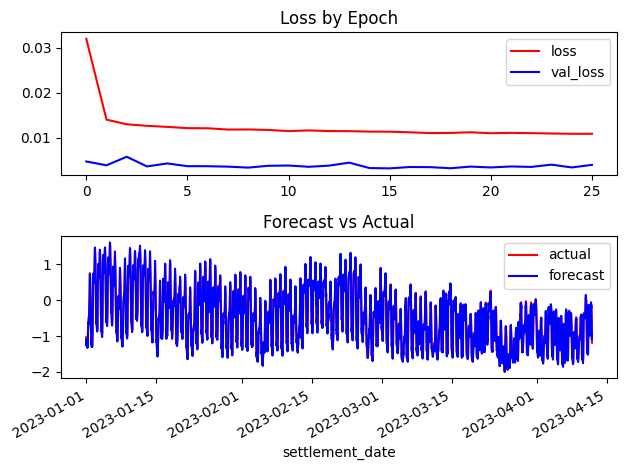

In [ ]:
plot_forecast(lstm_2_model, x_test, y_test, test.index, history_2)

In [ ]:
predicted_2 = lstm_2_model(x_test)

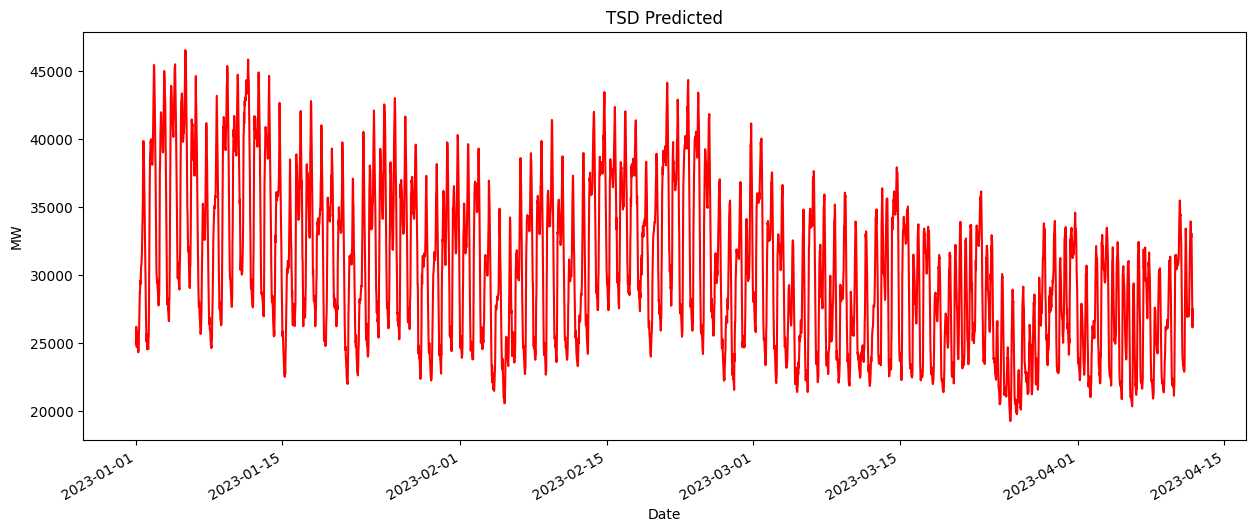

In [ ]:
shw_test_pred(predicted_2)

In [ ]:
future_pred = multi_step_forecast(x_test_pred, lstm_model)
future_pred = future_pred.reshape(12000,1)

Streaming output truncated to the last 5000 lines.
tf.Tensor([[-0.4629648]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.50589633]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.5558419]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.6092695]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.66242266]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.7118629]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.755165]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.7915212]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8219459]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8489015]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.8754493]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.90428245]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9370129]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.9738878]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.0138792]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.0550104]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.0948054]], shape=(1, 1), dtype=float32)
tf.Tensor([[

<Axes: xlabel='Date', ylabel='MW'>

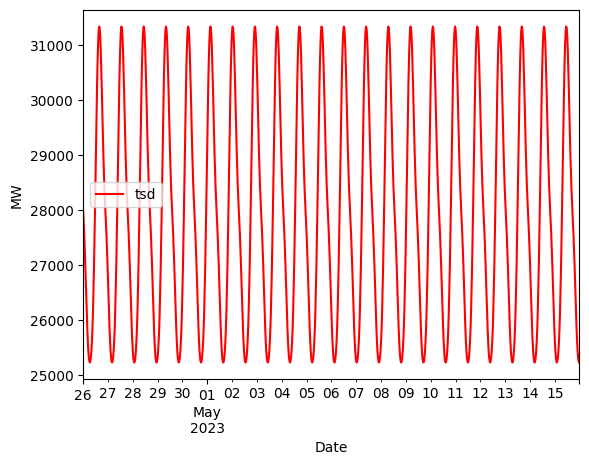

In [ ]:
df_future = pd.DataFrame(future_pred)
df_future.index = date_to_pred
df_future.columns = ['tsd']

df_fu = denorm_y(train_mean,train_std,df_future)
df_fu_t = df_fu[:960]
df_fu_t.plot(xlabel = "Date", ylabel = "MW", c='red', )

## CNN-LSTM

In [ ]:
#CNN-LSTM

cnn_lstm = Sequential()
cnn_lstm.add(layers.Conv1D(32, 5, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2])))
cnn_lstm.add(layers.MaxPooling1D(3))
cnn_lstm.add(layers.Conv1D(32, 5, activation='relu'))
cnn_lstm.add(layers.MaxPooling1D(3))
cnn_lstm.add(layers.LSTM(64))
cnn_lstm.add(layers.Dropout(0.2))
cnn_lstm.add(layers.Dense(1))

cnn_lstm.summary()

cnn_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError()])
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
history_cnn = cnn_lstm.fit(x_train, y_train, shuffle=False, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 668, 32)           192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 222, 32)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 218, 32)           5152      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 72, 32)           0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [ ]:
cnn_lstm.save('/content/drive/MyDrive/cnn_lstm.keras')

152/152 [==============================] - 1s 4ms/step


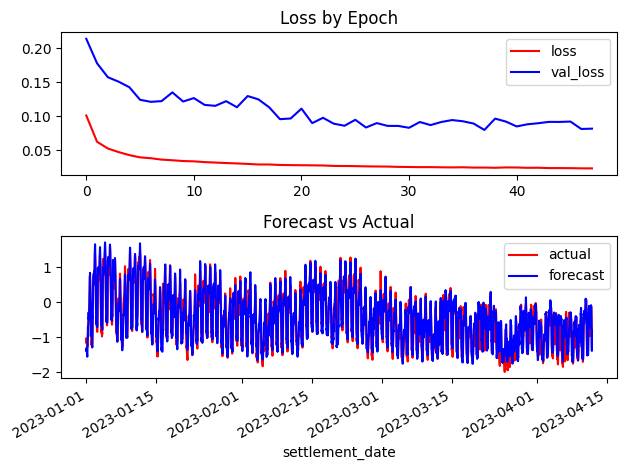

In [ ]:
plot_forecast(cnn_lstm, x_test, y_test, test.index, history_cnn)

In [ ]:
future_pred = multi_step_forecast(x_test_pred, lstm_model)
future_pred = future_pred.reshape(12000,1)

tf.Tensor([[-1.0643504]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.1034796]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.1382792]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.1668978]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.18831]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.202327]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.2093534]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.2099972]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.2046835]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.1933987]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.1756232]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.1504419]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.1167845]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.0737354]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.0208559]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.95846665]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.88784266]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.81128275]], shape=(1, 1), dtype=float32)
tf.Tensor(

In [ ]:
df_future = pd.DataFrame(future_pred)
df_future.index = date_to_pred
df_future.columns = ['tsd']

df_fu = denorm_y(train_mean,train_std,df_future)
df_fu_t = df_fu[:960]
df_fu_t.plot(xlabel = "Date", ylabel = "MW", c='red', )

In [ ]:
df_fu_t = df_fu[-960:]
df_fu_t.plot(xlabel = "Date", ylabel = "MW", c='red', )